In [50]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd, PyDSTool as dst
from PyDSTool import args
sn.set_context('notebook')

# Getting to grips with PyDSTool

## Background

For a diffuse pollution modelling project, I have a set of coupled, first order ODEs that I’d like to solve using Python. 
The real problem involves lots of ODEs, some of which have no analytical solution. At the moment, however, I’m just trying to learn the basics by solving a simplified (but similar) problem for which an analytical solution is possible. 

This notebook documents what I've tried so far. 

## The model

My “toy” problem involves building a **simple hydrological model** consisting of two “buckets”

<img src="https://drive.google.com/uc?export=&id=0BximeC_RweaeaHNhNUYwZjFWaXc" alt="Two bucket model" height="400" width=400> 

Both buckets are initially **empty**. The first bucket then receives an input flow of $H$, and the outflow from the bucket, $S$, is assumed to be directly proportional to the volume of water in the reservoir, $V_s$. The constant of proportionality is conventionally expressed as $\frac{1}{\tau_s}$, where $\tau_s$ is the “**residence time**” of the bucket. For the first bucket:

$$\frac{dV_s}{dt} = (H – S) \qquad and \qquad S = \frac{V_s}{\tau_s}$$

These expressions can be combined to give

$$\frac{dS}{dt} = \frac{(H – S)}{\tau_s}$$

A fraction of the water, $\beta$, leaving the first bucket enters the second bucket. The flow rate from the second bucket is denoted $G$ and, in the same way, the rate of change of $G$ is given by:

$$\frac{dG}{dt} = \frac{(\beta S - G)}{\tau_g}$$

## Aims

  1. Calculate how $S$ and $G$ vary with time. <br><br>
  2. Calculate the total volume of water draining via the $S$ pathway (denoted $D_s$) and via the $G$ pathway (denoted $D_g$) over the course of the simulation. $D_s$ and $D_g$ are simply the integrals of $S$ and $G$ respectively:

$$\frac{dD_s}{dt} = (1 - \beta) S \qquad and \qquad \frac{dD_g}{dt} = G$$

The factor of $(1 - \beta)$ is explained on the diagram above.

## Attempt 1: Constant, positive H

For a constant input, $H \geq 0$, the code below based on the PyDSTool tutorial seems to work OK.

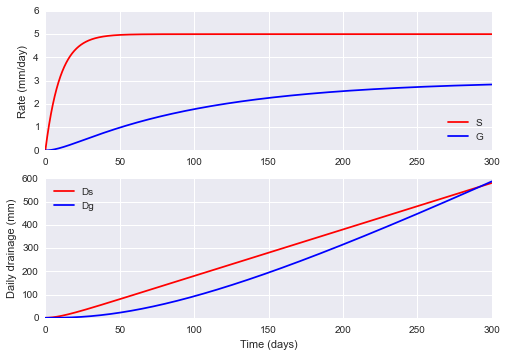

In [51]:
# Define constants
H = 5.         # HER (mm/day)
beta = 0.6     # BFI (dimensionless)
T_s = 10.      # Soil residence time (days)
T_g = 100.     # Groundwater residence time (days)

# Define initial conditions (all boxes empty)
S0 = 0.     # Soil outflow (mm/day)
G0 = 0.     # Groundwater outflow (mm/day)   
Ds0 = 0.    # Soil drainage volume (mm)
Dg0 = 0.    # Groundwater drainage volume (mm)

# Number of days to simulate
days = 300

# Build PyDSTool model
# Define parameters
par_dict = {'H':H, 'beta':beta, 'T_s':T_s, 'T_g':T_g}

# Define initial conditions
ic_dict = {'S':S0, 'G':G0, 'Ds':Ds0, 'Dg':Dg0}

# Define ODEs
dS_dt = '(H - S)/T_s'       # Soil outflow rate (mm/day)
dG_dt = '(beta*S - G)/T_g'  # Groundwater outflow rate (mm/day)
dDs_dt = '(1 - beta)*S'     # Accumulated soil drainage to stream (mm)
dDg_dt = 'G'                # Accumulated groundwater drainage to stream (mm)

# Define variables
var_dict = {'S':dS_dt, 'G':dG_dt, 'Ds':dDs_dt, 'Dg':dDg_dt}

# Add to model
DSargs = args(name='two_bucket_model')  
DSargs.ics = ic_dict               
DSargs.pars = par_dict             
DSargs.tdata = [0, days]           
DSargs.varspecs = var_dict

DS = dst.Generator.Vode_ODEsystem(DSargs)

# Solve and extract results
traj = DS.compute('model')
pts = traj.sample()

# Convert to pandas df
df = pd.DataFrame(data={'S':pts['S'], 
                        'G':pts['G'], 
                        'Ds':pts['Ds'], 
                        'Dg':pts['Dg']}, 
                  index=pts['t'])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(df.index, df['S'], 'r-', label='S')
axes[0].plot(df.index, df['G'], 'b-', label='G')
axes[0].set_ylabel('Rate (mm/day)')
axes[0].legend(loc='best')

axes[1].plot(df.index, df['Ds'], 'r-', label='Ds')
axes[1].plot(df.index, df['Dg'], 'b-', label='Dg')
axes[1].set_ylabel('Daily drainage (mm)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(loc='best')

plt.show()

## Attempt 2: H is a discrete daily time series

In reality, $H$ is not a constant: it is a daily time series of **hydrologically effective rainfall**. For this rough example, we'll use some real data but won't worry about where it comes from. 

In [52]:
# Download Tarland data
data_url = r'https://drive.google.com/uc?export=&id=0BximeC_RweaecHNIZF9GMHkwaWc'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)
del met_df['Q_Cumecs']

# Calculate H as Rainfall - 0.75*PET
met_df['HER_mm'] = met_df['Rainfall_mm'] - 0.75*met_df['PET_mm']

# Take the absolute value of any values < 0
met_df['HER_Pos_mm'] = abs(met_df['HER_mm'])

# Drop any NoData rows
met_df.dropna(how='any', inplace=True)

print met_df.head()

            Rainfall_mm  PET_mm  HER_mm  HER_Pos_mm
Date                                               
2000-01-01         0.10    0.72   -0.44        0.44
2000-01-02         1.00    0.72    0.46        0.46
2000-01-03         1.10    0.72    0.56        0.56
2000-01-04         1.38    0.72    0.84        0.84
2000-01-05         3.62    0.72    3.08        3.08


The PyDSTool documentation [talks about](http://www.ni.gsu.edu/~rclewley/PyDSTool/Generators.html#Time-series_trajectories_and_lookup_tables) using models with discrete time series. Unfortunately it doesn't give much detail and I suspect this may be **too difficult** for me at present?

As an alternative, how about running the solver in a loop? In other words:

  1. Run it for the first step in the time series with the first value for $H$. <br><br>
  2. Work out the drainage during the step and also the final outflow rates for $S$ and $G$. <br><br>
  3. Update the initial conditions and run the solver for the second step, with the appropriate value for $H$, and so on.

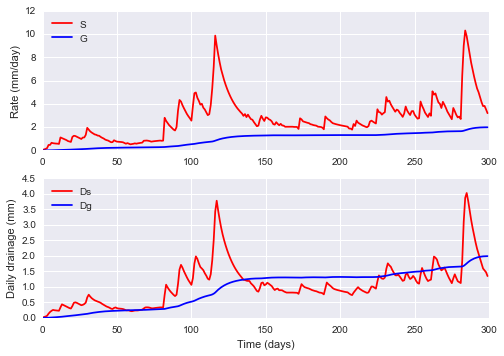

In [53]:
# Define constants
beta = 0.6     # BFI (dimensionless)
T_s = 10.      # Soil residence time (days)
T_g = 100.     # Groundwater residence time (days)

# Define initial conditions (all boxes empty)
S0 = 0.     # Soil outflow (mm/day)
G0 = 0.     # Groundwater outflow (mm/day)   
Ds0 = 0.    # Soil drainage volume (mm)
Dg0 = 0.    # Groundwater drainage volume (mm)

# Number of days to simulate
days = 300

# Build PyDSTool model
# Define parameters. Note that H will be reset below
par_dict = {'H':0, 'beta':beta, 'T_s':T_s, 'T_g':T_g}

# Define initial conditions
ic_dict = {'S':S0, 'G':G0, 'Ds':Ds0, 'Dg':Dg0}

# Define ODEs
dS_dt = '(H - S)/T_s'       # Soil outflow rate (mm/day)
dG_dt = '(beta*S - G)/T_g'  # Groundwater outflow rate (mm/day)
dDs_dt = '(1 - beta)*S'     # Accumulated soil drainage to stream (mm)
dDg_dt = 'G'                # Accumulated groundwater drainage to stream (mm)

# Define variables
var_dict = {'S':dS_dt, 'G':dG_dt, 'Ds':dDs_dt, 'Dg':dDg_dt}

# Add to model
DSargs = args(name='two_bucket_model')  
DSargs.ics = ic_dict               
DSargs.pars = par_dict             
DSargs.tdata = [0, 1]           
DSargs.varspecs = var_dict

DS = dst.Generator.Vode_ODEsystem(DSargs)

# List to store output
out_list = []

# Loop over discrete H time series
for step in range(days):
    # Get H for this step
    H = float(met_df['HER_Pos_mm'].ix[step])

    # Set H in model
    DS.set(pars={'H':H})
    
    # Extract results
    traj = DS.compute('model')
    pts = traj.sample()[-1] # Get only the last values (for t=1)
       
    # Append results
    out_list.append([pts['S'], pts['G'], pts['Ds'], pts['Dg']])
    
    # Update initial condition for next step
    DS.set(ics={'S':pts['S'],
                'G':pts['G']})
    
df = pd.DataFrame(data=np.vstack(out_list), columns=['S', 'G', 'Ds', 'Dg'])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(df.index, df['S'], 'r-', label='S')
axes[0].plot(df.index, df['G'], 'b-', label='G')
axes[0].set_ylabel('Rate (mm/day)')
axes[0].legend(loc='best')

axes[1].plot(df.index, df['Ds'], 'r-', label='Ds')
axes[1].plot(df.index, df['Dg'], 'b-', label='Dg')
axes[1].set_ylabel('Daily drainage (mm)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(loc='best')

plt.show()

This seems to work OK.

## Attempt 3: H can be negative

In reality, evapotranspiration may exceed precipitation, which means that $H$ is **negative**. Repeating exactly the same code as above, but this time using the "real" $H$ time series (with negative values) gives undesirable results - see below. This is because there is nothing to prevent $S$ (and therefore $G$, $D_s$ and $D_g$) from going negative, although this is clearly **not physically meaningful**.  

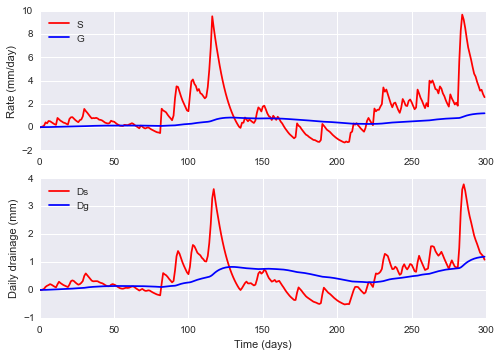

In [54]:
# Define constants
beta = 0.6     # BFI (dimensionless)
T_s = 10.      # Soil residence time (days)
T_g = 100.     # Groundwater residence time (days)

# Define initial conditions (all boxes empty)
S0 = 0.     # Soil outflow (mm/day)
G0 = 0.     # Groundwater outflow (mm/day)   
Ds0 = 0.    # Soil drainage volume (mm)
Dg0 = 0.    # Groundwater drainage volume (mm)

# Number of days to simulate
days = 300

# Build PyDSTool model
# Define parameters. Note that H will be reset below
par_dict = {'H':0, 'beta':beta, 'T_s':T_s, 'T_g':T_g}

# Define initial conditions
ic_dict = {'S':S0, 'G':G0, 'Ds':Ds0, 'Dg':Dg0}

# Define ODEs
dS_dt = '(H - S)/T_s'       # Soil outflow rate (mm/day)
dG_dt = '(beta*S - G)/T_g'  # Groundwater outflow rate (mm/day)
dDs_dt = '(1 - beta)*S'     # Accumulated soil drainage to stream (mm)
dDg_dt = 'G'                # Accumulated groundwater drainage to stream (mm)

# Define variables
var_dict = {'S':dS_dt, 'G':dG_dt, 'Ds':dDs_dt, 'Dg':dDg_dt}

# Add to model
DSargs = args(name='two_bucket_model')  
DSargs.ics = ic_dict               
DSargs.pars = par_dict             
DSargs.tdata = [0, 1]           
DSargs.varspecs = var_dict

DS = dst.Generator.Vode_ODEsystem(DSargs)

# List to store output
out_list = []

# Loop over discrete H time series
for step in range(days):
    # Get H for this step
    H = float(met_df['HER_mm'].ix[step])

    # Set H in model
    DS.set(pars={'H':H})
    
    # Extract results
    traj = DS.compute('model')
    pts = traj.sample()[-1] # Get only the last values (for t=1)
       
    # Append results
    out_list.append([pts['S'], pts['G'], pts['Ds'], pts['Dg']])
    
    # Update initial condition for next step
    DS.set(ics={'S':pts['S'],
                'G':pts['G']})
    
df = pd.DataFrame(data=np.vstack(out_list), columns=['S', 'G', 'Ds', 'Dg'])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(df.index, df['S'], 'r-', label='S')
axes[0].plot(df.index, df['G'], 'b-', label='G')
axes[0].set_ylabel('Rate (mm/day)')
axes[0].legend(loc='best')

axes[1].plot(df.index, df['Ds'], 'r-', label='Ds')
axes[1].plot(df.index, df['Dg'], 'b-', label='Dg')
axes[1].set_ylabel('Daily drainage (mm)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(loc='best')

plt.show()

PyDSTool has methods for detecting "**zero crossing events**". One option from the tutorials is to detect when $S$ reaches zero and to stop the integration there. The algorithm then returns the amount of drainage up to that point. This is implemented in the code below.

As far as I can tell, the *ZeroCrossEvent* function tracks events to within a specified tolerance ($1 \times 10^{-6} \; mm/day$ in the code below). When an event is triggered, $S$ can still end up being very small and negative (e.g. $-1 \times 10^{-7} \; mm/day$) and this causes problems later because the negative value becomes the initial condition for the next step. To avoid this, I've added an "if" statement to set any negative values of $S$ back to zero before moving to the next daily time step.

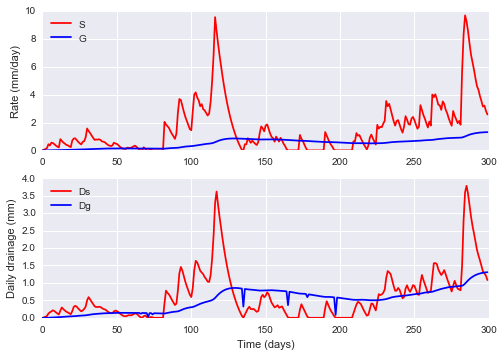

In [55]:
# Define constants
beta = 0.6     # BFI (dimensionless)
T_s = 10.      # Soil residence time (days)
T_g = 100.     # Groundwater residence time (days)

# Define initial conditions (all boxes empty)
S0 = 0.     # Soil outflow (mm/day)
G0 = 0.     # Groundwater outflow (mm/day)   
Ds0 = 0.    # Soil drainage volume (mm)
Dg0 = 0.    # Groundwater drainage volume (mm)

# Number of days to simulate
days = 300

# Build PyDSTool model
# Define parameters. Note that H will be reset below
par_dict = {'H':0, 'beta':beta, 'T_s':T_s, 'T_g':T_g}

# Define initial conditions
ic_dict = {'S':S0, 'G':G0, 'Ds':Ds0, 'Dg':Dg0}

# Define ODEs
dS_dt = '(H - S)/T_s'       # Soil outflow rate (mm/day)
dG_dt = '(beta*S - G)/T_g'  # Groundwater outflow rate (mm/day)
dDs_dt = '(1 - beta)*S'     # Accumulated soil drainage to stream (mm)
dDg_dt = 'G'                # Accumulated groundwater drainage to stream (mm)

# Define variables
var_dict = {'S':dS_dt, 'G':dG_dt, 'Ds':dDs_dt, 'Dg':dDg_dt}

# Define an "event" for terminating the integration if soil store dries out
event_S_0 = dst.makeZeroCrossEvent('S', 0,
                                   {'name': 'soil_dry',
                                    'eventtol': 1e-6,
                                    'term': True,
                                    'active': True},
                                   varnames=['S'])

# Add to model
DSargs = args(name='two_bucket_model')  
DSargs.events = [event_S_0]
DSargs.ics = ic_dict               
DSargs.pars = par_dict             
DSargs.tdata = [0, 1]           
DSargs.varspecs = var_dict

DS = dst.Generator.Vode_ODEsystem(DSargs)

# List to store output
out_list = []

# Loop over discrete H time series
for step in range(days):
    # Get H for this step
    H = float(met_df['HER_mm'].ix[step])

    # Set H in model
    DS.set(pars={'H':H})
    
    # Extract results
    traj = DS.compute('model')
    pts = traj.sample()[-1] # Get only the last values (for t=1)

    # Set any small negative values back to zero (see text above)
    for key in pts.keys():
        if pts[key]<0:
            pts[key]=0
            
    # Append results
    out_list.append([pts['S'], pts['G'], pts['Ds'], pts['Dg']])
    
    # Update initial condition for next step
    DS.set(ics={'S':pts['S'],
                'G':pts['G']})
    
df = pd.DataFrame(data=np.vstack(out_list), columns=['S', 'G', 'Ds', 'Dg'])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(df.index, df['S'], 'r-', label='S')
axes[0].plot(df.index, df['G'], 'b-', label='G')
axes[0].set_ylabel('Rate (mm/day)')
axes[0].legend(loc='best')

axes[1].plot(df.index, df['Ds'], 'r-', label='Ds')
axes[1].plot(df.index, df['Dg'], 'b-', label='Dg')
axes[1].set_ylabel('Daily drainage (mm)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(loc='best')

plt.show()

This is looking more promising, but there are still some issues to overcome. In particular, there are some **odd spikes** in the plot above for $D_g$, which coincide with the times when the soil store first dries out. 

When the soil store is emptied an "event" is triggered which stops the integration for the time step in question. This is correct for the soil store, but of course the groundwater store (bucket 2) should **keep on draining**. I assume the sudden spikes in the plot are due to the groundwater drainage being (incorrectly) interrupted part-way through a time step(?).

Instead of stopping the integration when the soil becomes dry, what I really need to do is continue to the end of the time step, but with the value of $S$ **artificially held at 0**. One way to do this is to introduce another loop, restarting the solver at the point in time where the soil dries out and running it to the end of the step with $H = S = 0$.

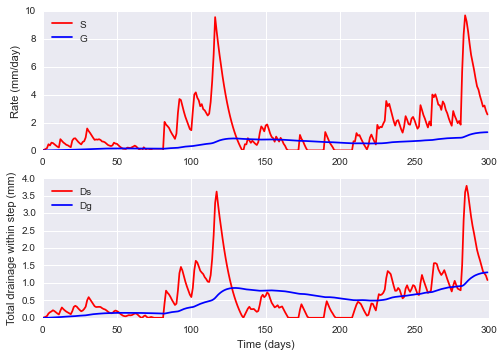

In [56]:
# Define constants
beta = 0.6     # BFI (dimensionless)
T_s = 10.      # Soil residence time (days)
T_g = 100.     # Groundwater residence time (days)

# Define initial conditions (all boxes empty)
S0 = 0.     # Soil outflow (mm/day)
G0 = 0.     # Groundwater outflow (mm/day)   
Ds0 = 0.    # Soil drainage volume (mm)
Dg0 = 0.    # Groundwater drainage volume (mm)

# Time params
steps = 300   # Number of steps to simulate
step_len = 1  # Length of each step in days

# Build PyDSTool model
# Define parameters. Note that H will be reset below
par_dict = {'H':0, 'beta':beta, 'T_s':T_s, 'T_g':T_g}

# Define initial conditions
ic_dict = {'S':S0, 'G':G0, 'Ds':Ds0, 'Dg':Dg0}

# Define ODEs
dS_dt = '(H - S)/T_s'       # Soil outflow rate (mm/day)
dG_dt = '(beta*S - G)/T_g'  # Groundwater outflow rate (mm/day)
dDs_dt = '(1 - beta)*S'     # Accumulated soil drainage to stream (mm)
dDg_dt = 'G'                # Accumulated groundwater drainage to stream (mm)

# Define variables
var_dict = {'S':dS_dt, 'G':dG_dt, 'Ds':dDs_dt, 'Dg':dDg_dt}

# Define an "event" for terminating the integration if soil store dries out
soil_dry = dst.makeZeroCrossEvent('S',
                                  -1,   # Only trigger in decreasing S direction
                                  {'name': 'soil_dry',
                                   'eventtol': 1e-6,
                                   'term': True,
                                   'active': True},
                                  varnames=['S'])

# Add to model
DSargs = args(name='two_bucket_model')  
DSargs.events = [soil_dry]
DSargs.ics = ic_dict               
DSargs.pars = par_dict             
DSargs.tdata = [0, step_len]           
DSargs.varspecs = var_dict

DS = dst.Generator.Vode_ODEsystem(DSargs)

# List to store output
out_list = []

# Loop over discrete H time series
for step in range(days):
    # Get H for this step
    H = float(met_df['HER_mm'].ix[step])
    
    # Set H in model
    DS.set(pars={'H':H})
    
    # Extract results
    traj = DS.compute('model')
    pts = traj.sample()[-1] # Get only the last values

    # Set any negative values back to zero (see text above)
    for key in pts.keys():
        if pts[key]<0:
            pts[key]=0
    
    # Check for events
    if DS.getEvents()['soil_dry']:
        # Get remaining time in this step
        t_rem = step_len - float(DS.getEvents()['soil_dry']['t'])
        
        # Restart the solver
        DS.set(pars={'H':0},
               ics={'S':0, 'G':pts['G']},
               tdata=[0, t_rem])
        traj = DS.compute('model')
        pts2 = traj.sample()[-1]
        
        # Update the results at the end of this step
        pts['S'] = 0                       # S must be 0 if we've entered this loop
        pts['G'] = pts2['G']               # pts2 give G for the true end of this step
        pts['Dg'] = pts['Dg'] + pts2['Dg'] # Total groundwater drainage is the sum of drainage
                                           # before and after the event
                                           # pts['Ds'] is unchanged as Ds after event must be 0
    
    # Append results
    out_list.append([pts['S'], pts['G'], pts['Ds'], pts['Dg']])
    
    # Update initial condition for next step
    DS.set(ics={'S':pts['S'], 'G':pts['G']},
           tdata=[0, step_len])
    
df = pd.DataFrame(data=np.vstack(out_list), columns=['S', 'G', 'Ds', 'Dg'])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(df.index, df['S'], 'r-', label='S')
axes[0].plot(df.index, df['G'], 'b-', label='G')
axes[0].set_ylabel('Rate (mm/day)')
axes[0].legend(loc='best')

axes[1].plot(df.index, df['Ds'], 'r-', label='Ds')
axes[1].plot(df.index, df['Dg'], 'b-', label='Dg')
axes[1].set_ylabel('Total drainage within step (mm)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(loc='best')

plt.show()

At first glance this seems to work, but it's rather messy and quite slow. I have a feeling that coding something like this for my full system will turn out to be very complicated and I'm sure there's a better way. The answer to [this Stackoverflow post](http://stackoverflow.com/questions/21366858/scipy-odeint-non-negative-solution/29571611#29571611) suggests it is possible to deal with these kinds of events in PyDSTool using a "**hybrid dynamical system**".

Something to investigate next...

## Attempt 4: Hybrid models

Based on Rob Clewley's answer to [my question on the PyDSTool forum](https://sourceforge.net/p/pydstool/discussion/472291/thread/1e2ee632/), I'm trying to build a simple hybrid model based on [this tutorial](http://www.ni.gsu.edu/~rclewley/PyDSTool/Tutorial/Tutorial_hybrid.pdf).

Let's ignore the discrete time series aspect for now and just try to get a hybrid system working that can switch from one model to another when the soil dries out during a time step.

We'll assume that the soil reservoir starts off partly filled and that $H$ is negative, so that the soil will eventually dry out. When this occurs, an event will be triggered to transition from a "**wet**" model to a "**dry**" one. The dry model only needs to consider equations for the (freely-draining) groundwater store, with the initial value of $G$ equal to the last value recorded by the wet model before the event was triggered.  

In [57]:
# Define constants
beta = 0.6     # BFI (dimensionless)
T_s = 10.      # Soil residence time (days)
T_g = 100.     # Groundwater residence time (days)

# Define initial conditions
H0 = -5.      # Input (mm/day)
S0 = 10.      # Soil outflow (mm/day)
G0 = 0.       # Groundwater outflow (mm/day)   
Ds0 = 0.      # Soil drainage volume (mm)
Dg0 = 0.      # Groundwater drainage volume (mm)

# Time params
step_len = 10 # Time step length (days)

# Build PyDSTool model
# Define ODEs
dS_dt = '(H - S)/T_s'       # Soil outflow rate (mm/day)
dG_dt = '(beta*S - G)/T_g'  # Groundwater outflow rate (mm/day)
dDs_dt = '(1 - beta)*S'     # Accumulated soil drainage to stream (mm)
dDg_dt = 'G'                # Accumulated groundwater drainage to stream (mm)
dGdry_dt = '-G/T_g'         # For dry model, when S = 0

# Define an "event" for switching models if soil store dries out
event_args = {'name':'soil_dry',
              'eventtol':1e-6,
              'term':True,
              'active':True}
soil_dry_ev = dst.makeZeroCrossEvent('S',                
                                     -1,           # Only trigger in decreasing S direction
                                     event_args,
                                     varnames=['S'])

# Build wet model
wet_args = {'pars':{'H':H0, 'beta':beta, 'T_s':T_s, 'T_g':T_g},
            'varspecs':{'S':dS_dt, 'G':dG_dt, 'Ds':dDs_dt, 'Dg':dDg_dt, 'is_dry':'0'},
            'xdomain':{'is_dry':0},
            'events':soil_dry_ev,
            'name':'wet'}
wet_model = dst.embed(dst.Generator.Vode_ODEsystem(wet_args), name='wet')

# Build dry model
dry_args = {'pars':{'T_g':T_g},
            'varspecs':{'G':dGdry_dt, 'Dg':dDg_dt, 'is_dry':'1'},
            'xdomain':{'is_dry':1},
            'ics':{'is_dry':1}, # Initial conditions for G and Dg in dry model need to be
            'name':'dry'}       # transferred across from wet model. Not sure how to do this?
                                # In Rob's example the linear model just picks up from where 
                                # the square spike model finishes, so perhaps this happens 
                                # automatically?
dry_model = dst.embed(dst.Generator.Vode_ODEsystem(dry_args), name='dry')

# Build hybrid model
mod_names = ['wet', 'dry']
wet_mi = dst.intModelInterface(wet_model)

# 'soil_dry' event triggers transition to 'dry' model
wet_info = dst.makeModelInfoEntry(wet_mi, mod_names, [('soil_dry', 'dry')]) 

# Not sure if these lines are necessary - I don't need a transition back to the wet model
# I just need to run the dry model to the end of the step?
dry_mi = dst.intModelInterface(dry_model)
dry_info = dst.makeModelInfoEntry(dry_mi, mod_names, [('time', 'wet')]) 

mod_info_dict = dst.makeModelInfo([wet_info, dry_info])
mod_args = {'name':'two_bucket_model', 'modelInfo':mod_info_dict}
model = dst.Model.HybridModel(mod_args)

# Compute trajectory
traj = model.compute('test',
                     ics={'S':S0, 'G':G0, 'Ds':Ds0, 'Dg':Dg0, 'is_dry':0},
                     tdata=[0, step_len])
pts = traj.sample()

# Convert to pandas df
df = pd.DataFrame(data={'S':pts['S'], 
                        'G':pts['G'], 
                        'Ds':pts['Ds'], 
                        'Dg':pts['Dg']}, 
                  index=pts['t'])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(df.index, df['S'], 'r-', label='S')
axes[0].plot(df.index, df['G'], 'b-', label='G')
axes[0].set_ylabel('Rate (mm/day)')
axes[0].legend(loc='best')

axes[1].plot(df.index, df['Ds'], 'r-', label='Ds')
axes[1].plot(df.index, df['Dg'], 'b-', label='Dg')
axes[1].set_ylabel('Daily drainage (mm)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(loc='best')

plt.show()

AttributeError: 'NoneType' object has no attribute 'sample'